In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def sample_normal_distribution(var):
    """
    Sample normal distribution with variance = var
    """
    rand = np.random.uniform(low=-1.0, high=1.0, size=12)
    return var * np.sum(rand) / 6


def prob_normal_distribution(x, var):
    """
    Calculate value of PDF of p(X = x) given X having normal distribution
    """
    return np.exp(-x**2 / (2 * var)) / np.sqrt(2 * np.pi * var)

In [3]:
# Test value of PDF
dx = 0.01
x_arr = [-1 + i * dx for i in range(201)]
prob = np.array([prob_normal_distribution(x, 0.1) * dx for x in x_arr])
np.sum(prob)

0.998518184845532

In [5]:
def motion_model(x, u):
    """
    Compute motion model
    Input:
        x (np.ndarray) - shape (3,1) : robot location in 3D space
        u (np.ndarray) - shape (3,1) : motion command (robot velocities)
    Output:
        xt (np.ndarray) - shape (3,1) : new robot location
    """
    return x + u * delta_t
    

def measurement_model(x, m):
    """
    Compute measurement model given state x (robot loc.) & map m
    Input:
        x (np.ndarray) - shape (3,1) : robot location in 3D space
        m (np.ndarray) - shape (num_beacons,3) : location of all beacons in the map
    Output:
        z (np.ndarray) - shape (num_beacons,) : distance from robot to each beacons
    """
    return np.sqrt(np.sum((m - x.squeeze())**2, axis=1))


def simulation_step(x, u):
    """
    Perform 1 step of simulation
    Input:
        x (np.ndarray) - shape (3,1) : robot location in 3D space
        u (np.ndarray) - shape (3,1): motion command (robot velocities)
    Output:
        xt (np.ndarray) - shape (3,1) : new robot location
        zt (np.ndarray) - shape (num_beacons,) : measurement at new location
    """
    # Perturb motion command
    u_noise = np.array([sample_normal_distribution(var_v) for i in range(3)])
    u_hat = u + u_noise.reshape(-1, 1)
    
    # Compute new location
    xt = motion_model(x, u_hat)  # here xt is the ground truth of robot location
    
    # Compute expected value of measurement
    zt_bar = measurement_model(xt, m) 
    # Perturb measurement
    zt = zt_bar + np.array([sample_normal_distribution(var_z) for i in range(num_beacons)])
    
    return xt, zt

In [6]:
def prob_motion_model(xt, ut, x_tm1):
    """
    Probability of state xt conditioned on action ut & previous state x_tm1
    Input:
        xt (np.ndarray) - shape (3,1) : new robot location in 3D space
        ut (np.ndarray) - shape (3,1): motion command (robot velocities)
        x_tm1 (np.ndarray) - shape (3,1) : previous robot location in 3D space
    Return
        p(xt | ut, x_tm1) - scalar
    """
    real_velocity = (xt - x_tm1) / delta_t
    diff = (real_velocity - ut).squeeze()  # value of motion command noise
    return prob_normal_distribution(diff[0], var_v) * prob_normal_distribution(diff[1], var_v) * prob_normal_distribution(diff[2], var_v) 

In [7]:
def prob_measurement_model(zt, xt, m):
    """
    Probability of measurement zt conditioned on state xt & map m
    Input:
        zt (np.ndarray) - shape (num_beacons,) : latest measurement
        xt (np.ndarray) - shape (3,1) : current robot location in 3D space
        m (np.ndarray) - shape (num_beacons,m) : location of all beacons in the map
    Return
        p(zt | xt, m) - scalar
    """
    # calculate expected measurement
    z_hat = measurement_model(xt, m)
    # measurement noise
    noise = zt - z_hat
    # probability of measurement
    prob = 1.
    for i in range(num_beacons):
        prob *= prob_normal_distribution(noise[i], var_z)
    return prob
    

In [10]:
def grid_localization(p_tm1, ut, zt, m):
    """
    Implementation of grid localization algorithm
    Input:
        p_tm1 (np.ndarray) - (num_cells,): each element store coordinate of cell's COM (first 3) &
                                            cell probability
        ut (np.ndarray) - shape (3,1): motion command (robot velocities)
        zt (np.ndarray) - shape (num_beacons,) : latest measurement
        m (np.ndarray) - shape (num_beacons,m) : location of all beacons in the map
    """
    p_t = np.zeros(len(com_list))
    for k, xk in enumerate(com_list):
        # prediction
        p_xk = np.array([prob_motion_model(xk, ut, xi) for xi in com_list])
        p_bar = np.sum(p_xk * p_tm1)
        # measurement correction
        p_t[k] = p_bar * prob_measurement_model(zt, xk, m)
        
    # normalize p_t
    p_t /= np.sum(p_t)
    
    return p_t

In [4]:
# CONSTANT
a = 5.  # size of the environment

# feature-based map --> list of beacons coordinate
m = np.array([[0., 0., 0.],
              [a, 0., 0.],
              [a, a, a],
              [0., a, a]])  # each row defines 1 beacon
num_beacons = m.shape[0]

var_v = 1.  # m^2/s^2
var_z = 1.  # m^2

delta_t = 0.25  # sec


In [8]:
# Discretize parameters
delta = 0.5  # size of a voxel
num_interval = int(np.floor(a / delta))  # number of discrete interval in 1 dimentsion

# list of COM of each cell
com_list = []
for k in range(num_interval):
    for j in range(num_interval):
        for i in range(num_interval):
            # define the range of each size of the box
            _x = np.array([i * delta, (i + 1) * delta])
            _y = np.array([j * delta, (j + 1) * delta])
            _z = np.array([k * delta, (k + 1) * delta])
            # find center of mass of the box
            xx, yy, zz = np.meshgrid(_x, _y, _z)
            com_x = np.sum(xx) / 8.
            com_y = np.sum(yy) / 8.
            com_z = np.sum(zz) / 8.
            # store coordinate of COM & initialize probability of each box
            com_list.append(np.array([com_x, com_y, com_z]).reshape(-1, 1))
            

In [9]:
# initialize belief for position tracking & global localization
position_tracking = False

if position_tracking:
    p_init = np.array([0 for i in range(len(com_list))])
    p_init[0] = 1.
else:
    # global localization
    p_init = np.array([1. / a**3 for i in range(len(com_list))])

In [11]:
# initialize
t = 0
x_true = np.zeros((3, 1)) 
p_tm1 = p_init

u = np.array([[0.5, 0., 0.5]]).T  # keep constant for the whole trajectory

ground_truth = []
local_re = []
time = []

# main loop
while t < 5.:
    print("t = ", t)
    # advance simulation 1 step 
    x_true, z = simulation_step(x_true, u)
    
    # estimate new location
    p_t = grid_localization(p_tm1, u, z, m)
    
    # store ground truth & estimate
    ground_truth.append(x_true.reshape(1, -1))
    local_re.append(p_t)
    time.append(t)
    
    # update 
    t += delta_t
    p_tm1 = p_t

t =  0
t =  0.25
t =  0.5
t =  0.75
t =  1.0
t =  1.25
t =  1.5
t =  1.75
t =  2.0
t =  2.25
t =  2.5
t =  2.75
t =  3.0
t =  3.25
t =  3.5
t =  3.75
t =  4.0
t =  4.25
t =  4.5
t =  4.75


In [17]:
p_final = local_re[-1]

In [18]:
x = np.array([com[0, 0] for com in com_list])
y = np.array([com[1, 0] for com in com_list])
z = np.array([com[2, 0] for com in com_list])

Text(0.5, 0.92, 'Final Belief')

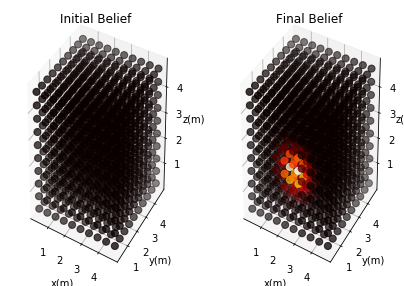

In [25]:
fig = plt.figure(figsize=(7, 5))
cmhot = plt.get_cmap("hot")

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, z, p_init, s=50, c=p_init, cmap=cmhot)
ax1.set_xlabel("x(m)")
ax1.set_ylabel("y(m)")
ax1.set_zlabel("z(m)")
ax1.set_title("Initial Belief")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x, y, z, p_final, s=50, c=p_final, cmap=cmhot)
ax2.set_xlabel("x(m)")
ax2.set_ylabel("y(m)")
ax2.set_zlabel("z(m)")
ax2.set_title("Final Belief")

In [22]:
ground_truth[-1]

array([[2.40724787, 0.50741963, 2.74564466]])

In [23]:
com_list[np.argmax(p_hist)]

array([[2.75],
       [0.75],
       [2.25]])